In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [5]:
week_days_path = "./data/paris_weekdays.csv"
week_ends_path = "./data/paris_weekends.csv"

paris_weekdays = pd.read_csv(week_days_path, index_col=0)
paris_weekends = pd.read_csv(week_ends_path, index_col=0)

paris_weekdays['is_weekend'] = 0
paris_weekends['is_weekend'] = 1

paris_all = pd.concat([paris_weekdays, paris_weekends], ignore_index=True)

print("Shape of combined dataset:", paris_all.shape)
print("Missing values:\n", paris_all.isnull().sum())


Shape of combined dataset: (6688, 20)
Missing values:
 realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
is_weekend                    0
dtype: int64


KeyboardInterrupt: 

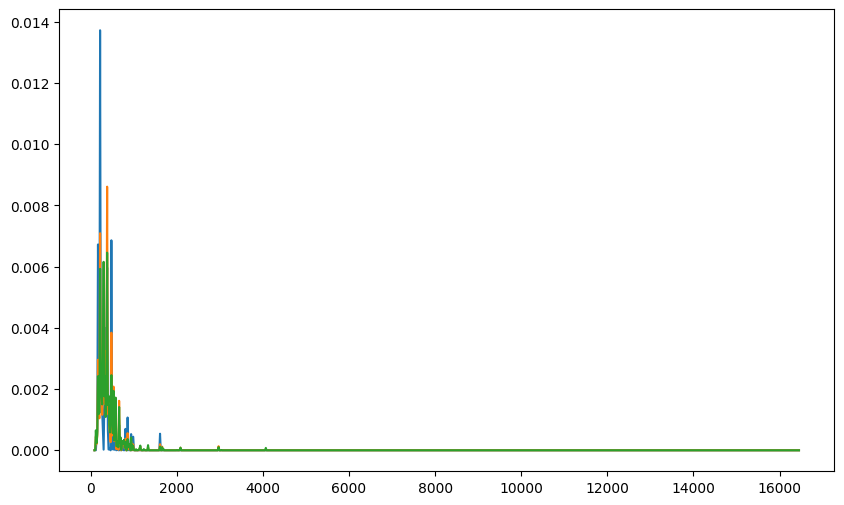

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

def K(x):
    return 1 / (math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)

def kde(x_all, x, h):
    m = len(x_all)
    sum_k = sum(K((x - xi) / h) for xi in x_all)
    return sum_k / (m * h)

def plot_kde_with_bandwidths(data, h_values, title):
    x_min, x_max = data.min() - 5, data.max() + 5
    x_plot = np.linspace(x_min, x_max, 1000)
    
    plt.figure(figsize=(10,6))
    
    for h in h_values:
        y_plot = [kde(data, xi, h) for xi in x_plot]
        plt.plot(x_plot, y_plot, label=f'h = {h}')
    
    plt.scatter(data, np.zeros_like(data), color='red', alpha=0.3, marker='|')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('realSum')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

h_values = [0.1, 0.3, 0.5, 1.0]
plot_kde_with_bandwidths(paris_all['realSum'].values, h_values, "KDE dla całego zbioru")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from numpy.linalg import inv

def get_outlier_rows(df, col, z_thresh=3):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[np.abs(z_scores) > z_thresh]

def mahalanobis_outliers(df, cols, threshold=0.99):
    data = df[cols].values
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = inv(cov)
    diff = data - mean
    m_dist = np.sqrt(np.sum(diff @ inv_covmat * diff, axis=1))
    
    critical_value = np.sqrt(chi2.ppf(threshold, df=len(cols)))
    outlier_mask = m_dist > critical_value
    return df[outlier_mask], m_dist

def plot_distribution_with_outliers(df, col):
    df = df[df["realSum"] < 15000]
    plt.figure(figsize=(8,4))
    plt.hist(df[col], bins=50, alpha=0.7, color='steelblue')
    outliers = get_outlier_rows(df, col, 4)
    if len(outliers) > 0:
        plt.scatter(outliers[col], [0]*len(outliers), color='red', label='Outliers', zorder=10)
    plt.title(f'Distribution with Outliers: {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return df[col].describe()

def plot_distribution_with_outliers_log(df, col):
    plt.figure(figsize=(8,4))
    plt.hist(df[col], bins=50, alpha=0.7, color='steelblue')
    outliers = get_outlier_rows(df, col)
    if len(outliers) > 0:
        plt.scatter(outliers[col], [0]*len(outliers), color='red', label='Outliers', zorder=10)
    plt.xscale('log')
    plt.title(f'Distribution with Outliers (Log Scale): {col}')
    plt.xlabel(col + ' (log scale)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    return df[col].describe()

def plot_kde_with_outliers(df, col, h=0.5, z_tresh=3):
    # df = df[df["realSum"] < 15000]
    data = df[col].values
    x_min, x_max = data.min() - 5, data.max() + 5
    x_plot = np.linspace(x_min, x_max, 1000)
    
    # Calculate KDE
    y_plot = [kde(data, xi, h) for xi in x_plot]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram on left
    ax1.hist(df[col], bins=50, alpha=0.7, color='steelblue')
    outliers = get_outlier_rows(df, col, z_thresh=z_tresh)
    if len(outliers) > 0:
        ax1.scatter(outliers[col] + 0.5, [0]*len(outliers), color='red', label='Outliers', zorder=10, s=50)
    ax1.set_title(f'Histogram with Outliers: {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # KDE on right
    ax2.plot(x_plot, y_plot, color='steelblue', linewidth=2, label=f'KDE (h={h})')
    ax2.set_title(f'KDE Distribution: {col}')
    ax2.set_xlabel(col)
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([-2, 2])
    
    plt.tight_layout()
    plt.show()
    return df[col].describe()

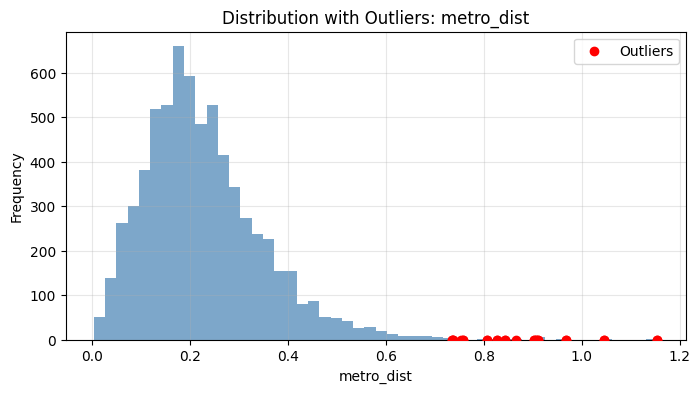

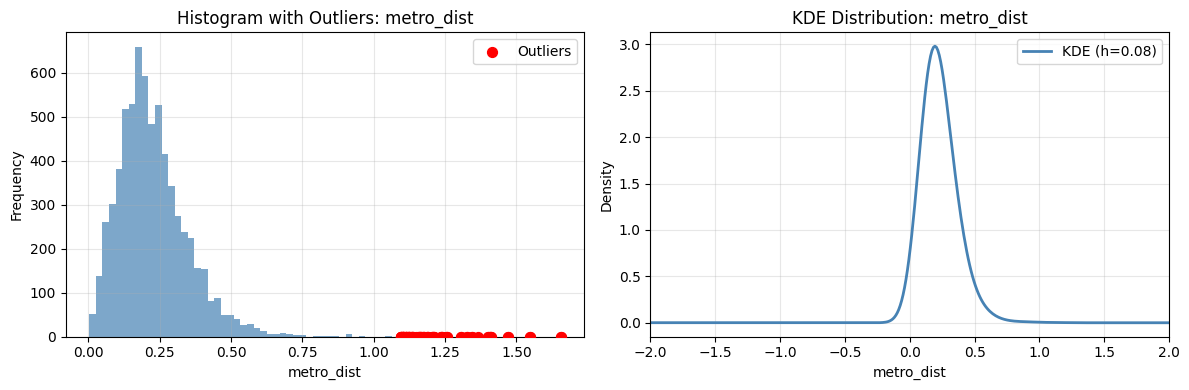

count    6688.000000
mean        0.227323
std         0.122769
min         0.003220
25%         0.142363
50%         0.207317
75%         0.290475
max         1.154777
Name: metro_dist, dtype: float64

In [15]:
col = "metro_dist"
outliers = get_outlier_rows(paris_all, col)
plot_distribution_with_outliers(paris_all, col)
plot_kde_with_outliers(paris_all, col, h=0.08)